As a UFC fan I'd like to share here my exploratory data analysis. On the dataset publicly available on Kaggle 

In [1]:
#imports 
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

<img src="https://www.thenationalnews.com/image/policy:1.1054478:1602128191/GettyImages-1258439122.jpg?$p=9b4f9dd&w=2048&$w=dbf56c5" length="100px" width="1000px">

In [2]:
# Data available
os.listdir('data')

['most-recent-event.csv', 'upcoming-event.csv', 'ufc-master.csv']

In [3]:
df = pd.read_csv('data/ufc-master.csv')
df.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,R_td_attempted_bout,B_td_attempted_bout,R_td_pct_bout,B_td_pct_bout,R_sub_attempts_bout,B_sub_attempts_bout,R_pass_bout,B_pass_bout,R_rev_bout,B_rev_bout
0,Anthony Smith,Devin Clark,-139,115,71.942446,115.0,11/28/2020,"Las Vegas, Nevada, USA",USA,Red,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Miguel Baeza,Takashi Sato,-175,140,57.142857,140.0,11/28/2020,"Las Vegas, Nevada, USA",USA,Red,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Josh Parisian,Parker Porter,-200,160,50.000000,160.0,11/28/2020,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Spike Carlyle,Bill Algeo,-177,140,56.497175,140.0,11/28/2020,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ashlee Evans-Smith,Norma Dumont,-137,110,72.992701,110.0,11/28/2020,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### General Introduction

<ipython-input-4-68542e85c8df>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ordered_weight_class'] = pd.Categorical(data['weight_class'], weight_class_order)


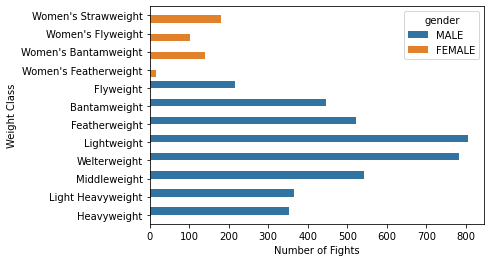

In [4]:
data=df[~df.weight_class.str.contains("Catch Weight")]
data.weight_class.unique()

weight_class_order = ["Women's Strawweight", "Women's Flyweight", "Women's Bantamweight", "Women's Featherweight",
                      "Flyweight", "Bantamweight", "Featherweight", "Lightweight", "Welterweight", 
                      "Middleweight", "Light Heavyweight", "Heavyweight"]
data['ordered_weight_class'] = pd.Categorical(data['weight_class'], weight_class_order)

sns.countplot(data=data.sort_values('ordered_weight_class', ascending=False) , y = 'ordered_weight_class' , hue ='gender')
plt.xlabel('Number of Fights')
plt.ylabel('Weight Class')
plt.show();

Catch_wieght is also present in the dataset, but it is not a weight category. When fighters fail to cut enough weight to make it in the division they agreed to fight in an offer to fight at Catch weight is made. It allows both fighters to have some extra pound (128 instead of 125 for instance).

/Users/hugovergnes/miniconda3/envs/plot/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='finish', ylabel='count'>

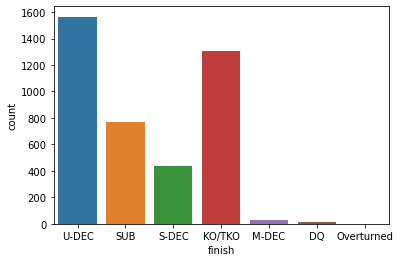

In [5]:
sns.countplot(df['finish'])

In [6]:
df["finish_details"].unique()

array([nan, 'Rear Naked Choke', 'Armbar', 'Guillotine Choke', 'Elbow',
       'Punches', 'Punch', 'Elbows', 'Knee', 'Triangle Choke',
       'Heel Hook', 'Kneebar', 'Kick', "D'Arce Choke", 'Anaconda Choke',
       'Arm Triangle', 'Knees', 'Ankle Lock', 'Flying Knee', 'Neck Crank',
       'Peruvian Necktie', 'Spinning Back Fist', 'Other - Choke',
       'Other - Lock', 'Slam', 'Spinning Back Kick', 'Kimura', 'Omoplata',
       'North-South Choke', 'Injury', 'Kicks', 'Keylock'], dtype=object)

/Users/hugovergnes/miniconda3/envs/plot/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='finish_details', ylabel='count'>

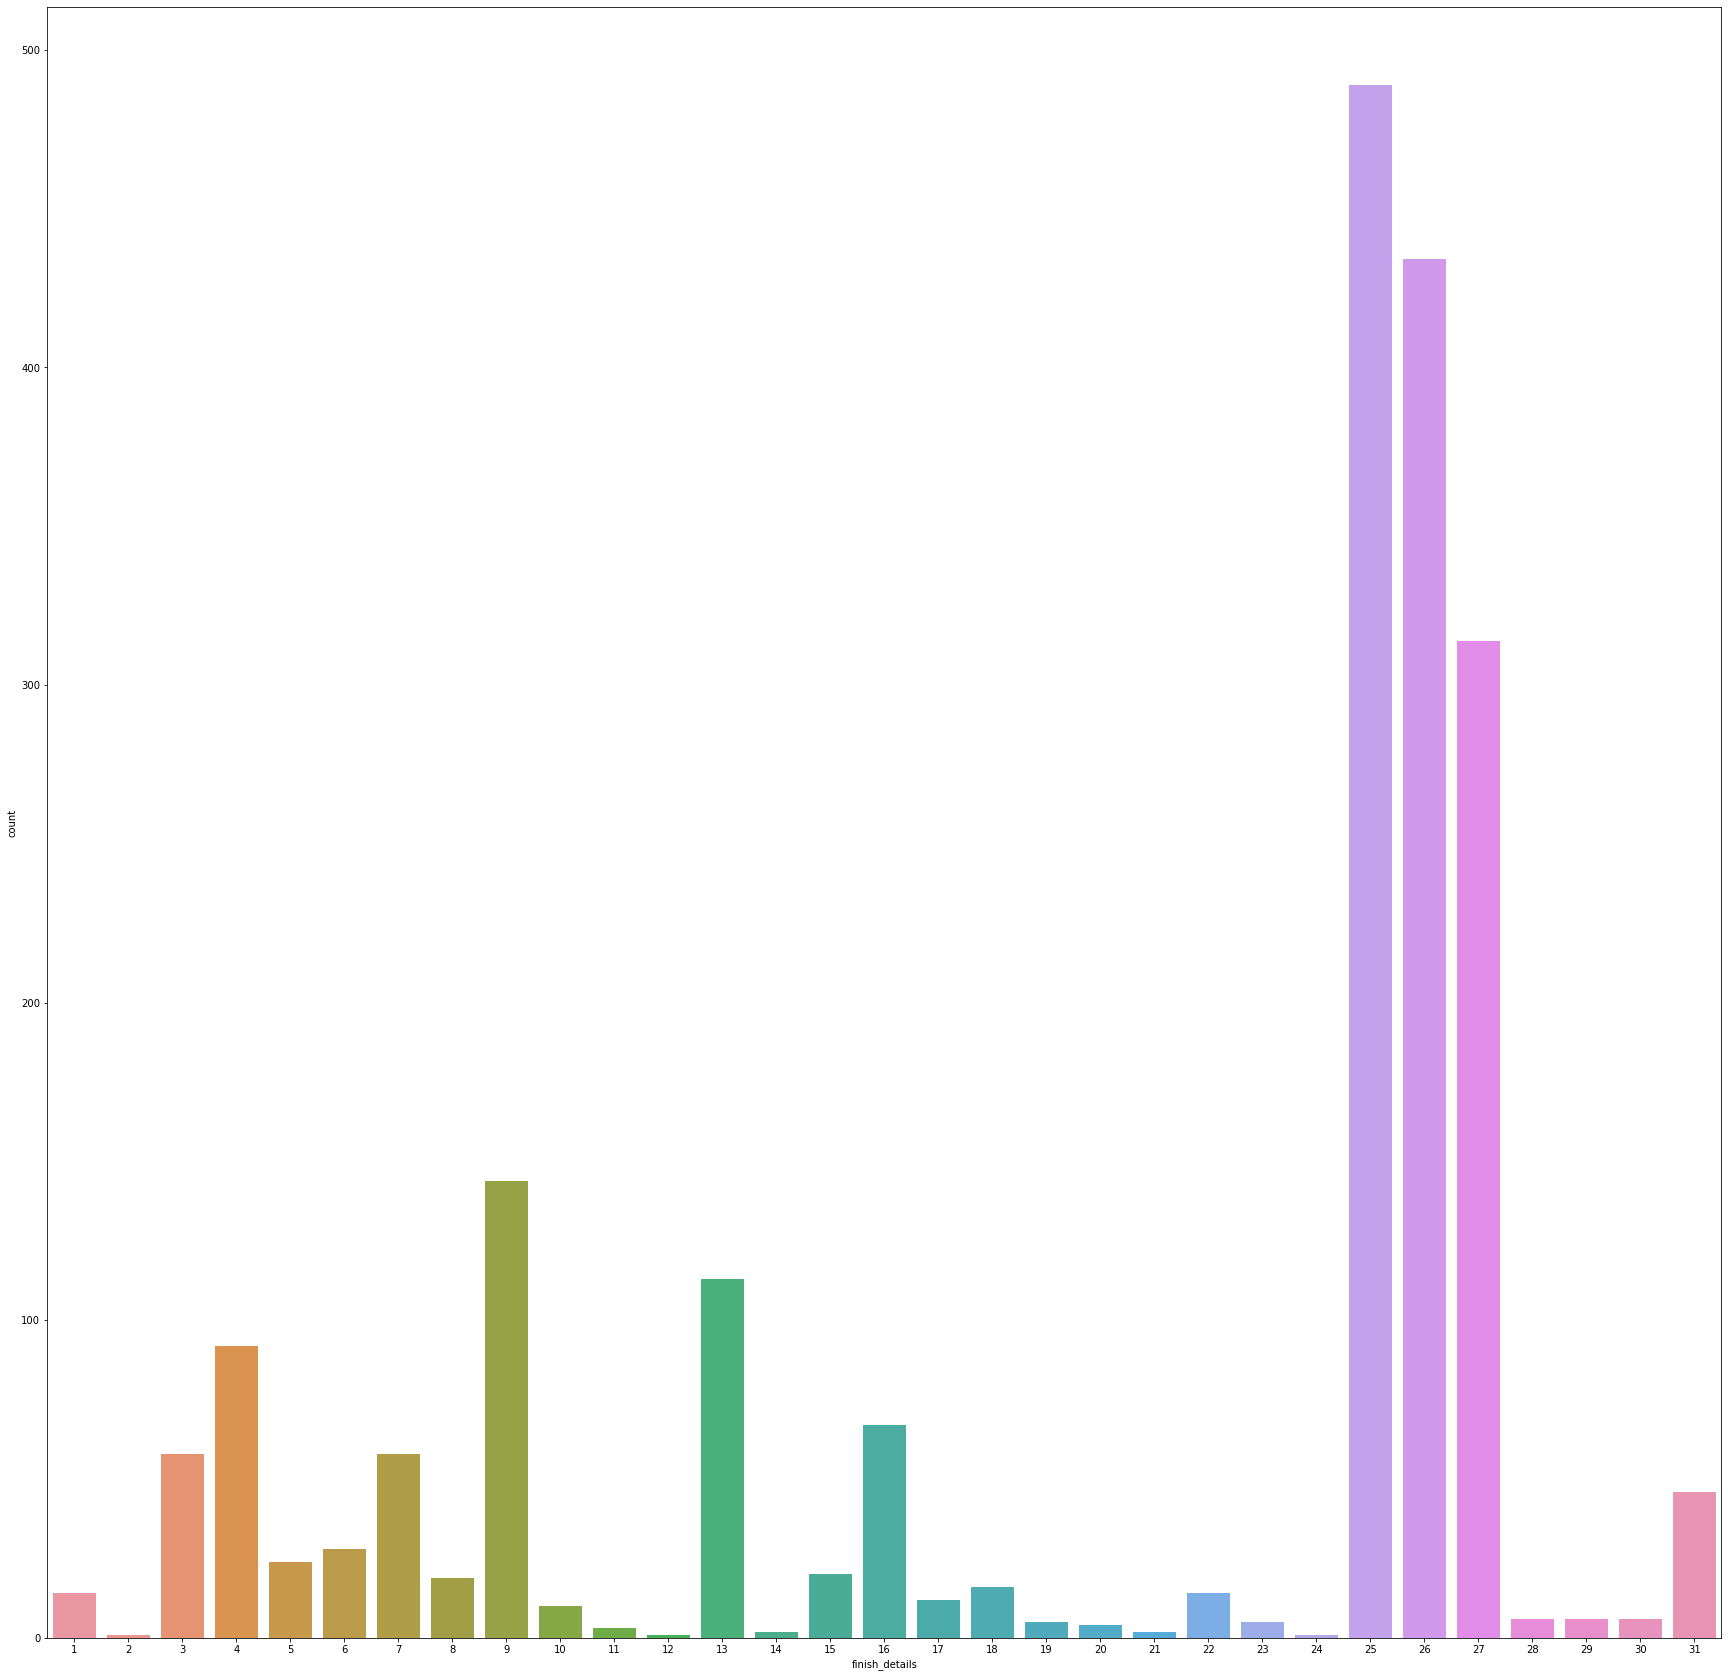

In [7]:
label = LabelEncoder()
df["finish_details"] = df["finish_details"].fillna('0')
label.fit(df['finish_details'])
label_name_mapping = dict(zip(label.classes_, label.transform(label.classes_)))
df["finish_details"] = label.transform(df["finish_details"])
plt.figure(figsize=(30, 30))
finish_det = df['finish_details'].loc[df['finish_details'] != 0]
sns.countplot(finish_det)

In [8]:
print(label_name_mapping)

{'0': 0, 'Anaconda Choke': 1, 'Ankle Lock': 2, 'Arm Triangle': 3, 'Armbar': 4, "D'Arce Choke": 5, 'Elbow': 6, 'Elbows': 7, 'Flying Knee': 8, 'Guillotine Choke': 9, 'Heel Hook': 10, 'Injury': 11, 'Keylock': 12, 'Kick': 13, 'Kicks': 14, 'Kimura': 15, 'Knee': 16, 'Kneebar': 17, 'Knees': 18, 'Neck Crank': 19, 'North-South Choke': 20, 'Omoplata': 21, 'Other - Choke': 22, 'Other - Lock': 23, 'Peruvian Necktie': 24, 'Punch': 25, 'Punches': 26, 'Rear Naked Choke': 27, 'Slam': 28, 'Spinning Back Fist': 29, 'Spinning Back Kick': 30, 'Triangle Choke': 31}


For the type of finish a lot of the data is unavailable (labeled zero), however for the amount of data we have we can clearly see that punches, and rear naked choke are significantly common for finishing strikes. Guillotine chokes is also a counter you can see in different matches.

/Users/hugovergnes/miniconda3/envs/plot/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='finish_round', ylabel='count'>

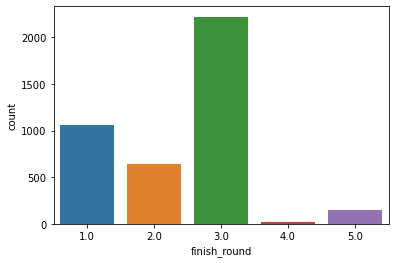

In [9]:
sns.countplot(df['finish_round'])

In [10]:
df['total_fight_time_secs'].fillna(0)

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
        ...  
4490     44.0
4491    121.0
4492     47.0
4493    900.0
4494    900.0
Name: total_fight_time_secs, Length: 4495, dtype: float64

Looks like there is a mistake here, as the minimum seems way to low, we will clip it in the plot.

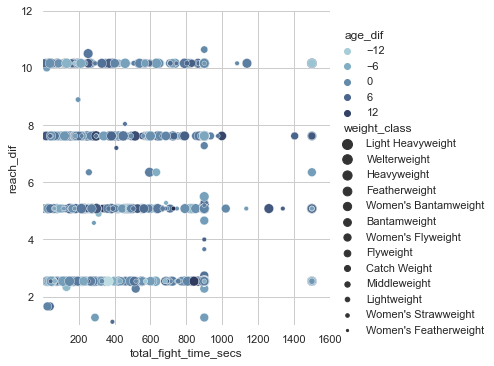

In [11]:
sns.set_theme(style="whitegrid")

# Load the example planets dataset
planets = sns.load_dataset("planets")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df,
    x="total_fight_time_secs", y="reach_dif",
    hue="age_dif", 
    size="weight_class",
    palette=cmap, sizes=(5, 100),
)
#g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.1)
g.ax.yaxis.grid(True, "minor", linewidth=.1)
plt.ylim(1, 12)
plt.xlim(1, 1600)
g.despine(left=True, bottom=True)

As we could expect, big age gap with small reach difference usually end up in a quick victory. Also, most fight are three rounds resulting in the vertical line at 900 seconds.

In [12]:
# There is a quick catch in the data for the countries where there is a white space for most the countries,
# Here is a quick fix, You might need to fix this if you want to use a model to predict betting odds
df['country'].unique()

array(['USA', 'United Arab Emirates', 'Brazil', ' USA', ' New Zealand',
       ' Canada', ' Uruguay', ' China', ' United Arab Emirates',
       ' Mexico', ' Denmark', ' Australia', ' Singapore', ' Russia',
       ' Brazil', ' South Korea', ' Sweden', ' United Kingdom',
       ' Czech Republic', ' Argentina', ' Germany', ' Chile', ' Poland',
       ' Japan', ' Netherlands', ' Croatia', ' Ireland', ' Philippines'],
      dtype=object)

In [13]:
# Quick fix
cond = (df['country'].str[0] != ' ')
df['country_fixed'] = df['country'].where(cond, df['country'].str[1:])

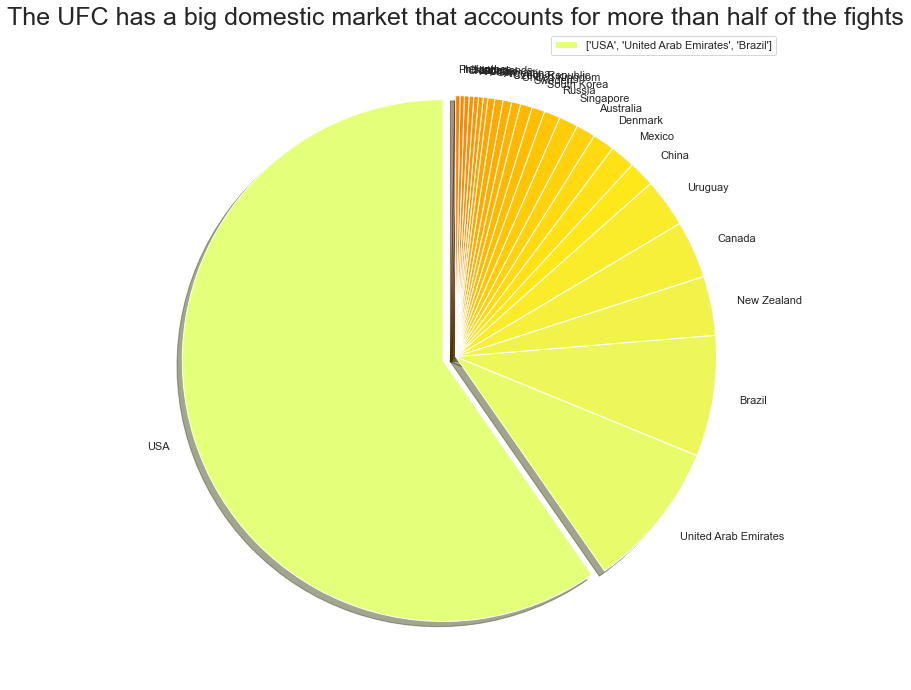

In [14]:
n_countries = len(df['country_fixed'].unique())
labels = list(df['country_fixed'].unique())
size = df['country_fixed'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, len(df['country_fixed'].unique())))
explode = [0 for i in range(n_countries)]
explode[0] = 0.05

plt.figure(figsize=(12, 12))
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('The UFC has a big domestic market that accounts for more than half of the fights', fontsize = 25)
plt.legend([labels[:3]])
plt.show()

### Who is the winner ? 

Text(0.5, 1.0, 'Winner of title bout')

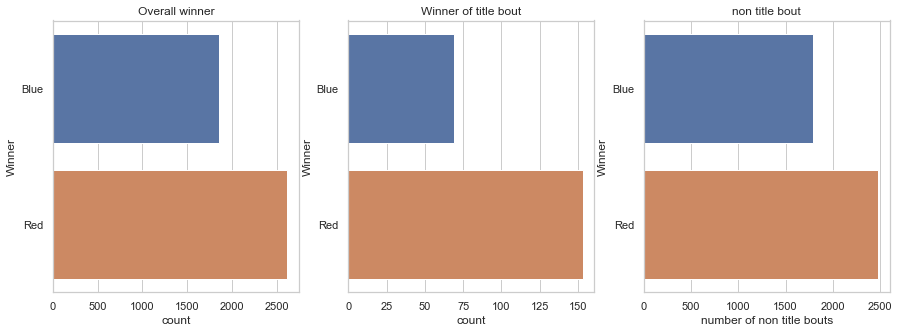

In [15]:
# all_fighters = pd.concat([df['R_fighter'], df['B_fighter']]).unique()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(ax=axes[0], data=data.sort_values('Winner'), y = 'Winner')

plt.xlabel('Number of Fights')
axes[0].set_title("Overall winner")
title_bouts = df[df['title_bout'] == True]
red_winner = title_bouts["Winner"][title_bouts['Winner'] == "Red"].count() / title_bouts["Winner"].count() * 100
blue_winner = title_bouts["Winner"][title_bouts['Winner'] == "Blue"].count() / title_bouts["Winner"].count() * 100
sns.countplot(ax=axes[1], data=title_bouts.sort_values("Winner"), y = "Winner")
plt.xlabel("number of title bouts")
axes[1].set_title("Winner of title bout")
non_title_bouts = df[df['title_bout'] == False]
red_winner = non_title_bouts["Winner"][non_title_bouts['Winner'] == "Red"].count() / non_title_bouts["Winner"].count() * 100
blue_winner = non_title_bouts["Winner"][non_title_bouts['Winner'] == "Blue"].count() / non_title_bouts["Winner"].count() * 100
sns.countplot(ax=axes[2], data=non_title_bouts.sort_values("Winner"), y = "Winner")
plt.xlabel("number of non title bouts")
plt.title("non title bout")
axes[1].set_title("Winner of title bout")

In [16]:
red_winner = df["Winner"][df['Winner'] == "Red"].count() / df["Winner"].count() * 100
blue_winner = df["Winner"][df['Winner'] == "Blue"].count() / df["Winner"].count() * 100
print(f"For non-title bouts, {red_winner:.2f}% of the time the winner is red, against {blue_winner:.2f}% for the blue corner")
title_bouts = df[df['title_bout'] == True]
red_winner = title_bouts["Winner"][title_bouts['Winner'] == "Red"].count() / title_bouts["Winner"].count() * 100
blue_winner = title_bouts["Winner"][title_bouts['Winner'] == "Blue"].count() / title_bouts["Winner"].count() * 100
print(f"For title bouts, {red_winner:.2f}% of the time the winner is red against, {blue_winner:.2f}%")

For non-title bouts, 58.55% of the time the winner is red, against 41.45% for the blue corner
For title bouts, 68.92% of the time the winner is red against, 31.08%


Here, it is important to notice that the champion usually comes out in the red corner. This represent a big bias in the data.

# So what about the odds ? 

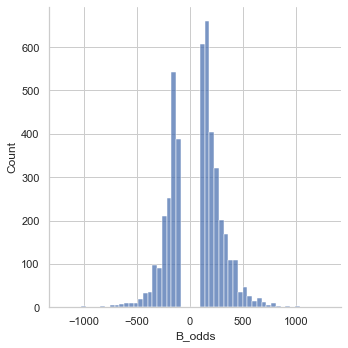

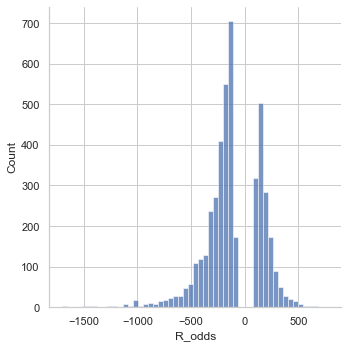

In [17]:
sns.displot(df, x="B_odds")
sns.displot(df, x="R_odds")

The Red corner seems to have safer bets, indeed once again the champion tends to come out of the red corner.

# Find the burning contenders

In this section, we are building a graph to show who are the hot contenders in UFC. Who has the best W/D ratio, so we mix a heatmap with the graph.

Before we begin, we have to notice that UFC is structured around weight classes, and thus if we want to draw a graph showing who fought who we will find communities (Unconnected subgraph). Indeed, very few fighters are fighting at different weight classes and when some do they are only moving one category up or down. Then we can split the problem by one graph per category. 

In [18]:
all_fighters = pd.concat([df['R_fighter'], df['B_fighter']]).unique()

In [19]:
def make_fighters_dict(df):
    fighters_summary = dict()
    for name in all_fighters:
        total_fights = df["Winner"][df["R_fighter"] == name].count() + df["Winner"][df["B_fighter"] == name].count()
        wins = df["Winner"][df["Winner"] == "Red"][df["R_fighter"] == name].count() + df["Winner"][df["Winner"] == "Blue"][df["B_fighter"] == name].count()
        losses = total_fights - wins
        fighters_summary[name] = (total_fights, wins, losses)
    return fighters_summary

fighters_summary = make_fighters_dict(df)

In [20]:
array_fighters = np.array(list(fighters_summary.values()))

In [21]:
fighters_df = pd.DataFrame({'name':fighters_summary.keys(), 'total_bouts': array_fighters[:, 0], 'K':array_fighters[:, 1], 'D': array_fighters[:, 2]})
fighters_df.describe()

,total_bouts,K,D
count,1659.000000,1659.000000,1659.000000
mean,5.418927,2.709464,2.709464
std,4.692077,3.240274,1.993046
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000
50%,4.000000,1.000000,2.000000
75%,7.000000,4.000000,4.000000
max,35.000000,23.000000,13.000000


In [22]:
def find_main_fighters(fighters_summary, threshold=16, categories=["all"]):
    if categories == ["all"]:
        main_fighters = {name: t for name, t in fighters_summary.items() if t[0] > threshold}
        print(f"There is {len(main_fighters)} with strictly more than {threshold} fights")
        return main_fighters
    else:
        main_fighters = {}
        for name, t in fighters_summary.items():
            if t[0] > threshold:
                if (df[df["R_fighter"] == name]["weight_class"].any() 
                    or df[df["R_fighter"] == name]["weight_class"].any())in categories:
                    main_fighters[name] = t
        print(f"There is {len(main_fighters)} fighters with strictly more than {threshold} fights in the categories {categories}")
        
    return main_fighters

main_fighters = find_main_fighters(fighters_summary, categories=["Lightweight", "Welterweight"])

There is 27 fighters with strictly more than 16 fights in the categories ['Lightweight', 'Welterweight']


We can focus on lightweight and welterweight, which are the two most represented weight catgories at 155 and 170 pounds. We often have fighters that are jumping from one category to another.

In [23]:
# main_fighters

In [24]:
name = "Colby Covington"
categories=["Lightweight", "Welterweight"]
(df[df["R_fighter"] == name]["weight_class"].any() or df[df["R_fighter"] == name]["weight_class"].any())in categories

True

In [25]:
def make_graph(df, fighters_summary):
    G = nx.Graph()
    G.add_nodes_from(list(fighters_summary.items()))
    for i, (name1, name2) in enumerate(zip(df["R_fighter"], df["B_fighter"])):
        names = [name[0] for name in list(G.nodes())]
        if name1 in names and name2 in names:
            G.add_edge(name1, name2)
    return G
        

In [26]:
G = make_graph(df, main_fighters)
isolated_nodes = [nodes for nodes in nx.isolates(G)]
while len(isolated_nodes) > 0:
    G.remove_node(isolated_nodes.pop())

{'Anthony Pettis': Text(-0.09461224821932518, 0.27804134536776837, 'Anthony Pettis'),
 'Donald Cerrone': Text(0.06651030758346736, -0.20242613298658957, 'Donald Cerrone'),
 'Kevin Lee': Text(0.5521492546025116, 0.19607964708241488, 'Kevin Lee'),
 'Charles Oliveira': Text(0.3004723322648303, 0.2874144889224449, 'Charles Oliveira'),
 'Francisco Trinaldo': Text(0.4110564095993695, 0.003759086283450624, 'Francisco Trinaldo'),
 'John Makdessi': Text(0.49855939240858144, -0.3668592055123211, 'John Makdessi'),
 'Jim Miller': Text(-0.006251929059537801, 0.3749743849848123, 'Jim Miller'),
 'Clay Guida': Text(-0.30976267008371916, 0.3337939760483909, 'Clay Guida'),
 'Tony Ferguson': Text(0.17564944873492794, 0.2938716556741588, 'Tony Ferguson'),
 'Rafael Dos Anjos': Text(0.09407788060364314, 0.02116859141889607, 'Rafael Dos Anjos'),
 'Nik Lentz': Text(0.8573006291284835, 0.578736781976694, 'Nik Lentz'),
 'Ross Pearson': Text(0.13803022763707562, -0.399566402641266, 'Ross Pearson'),
 'Dustin Poir

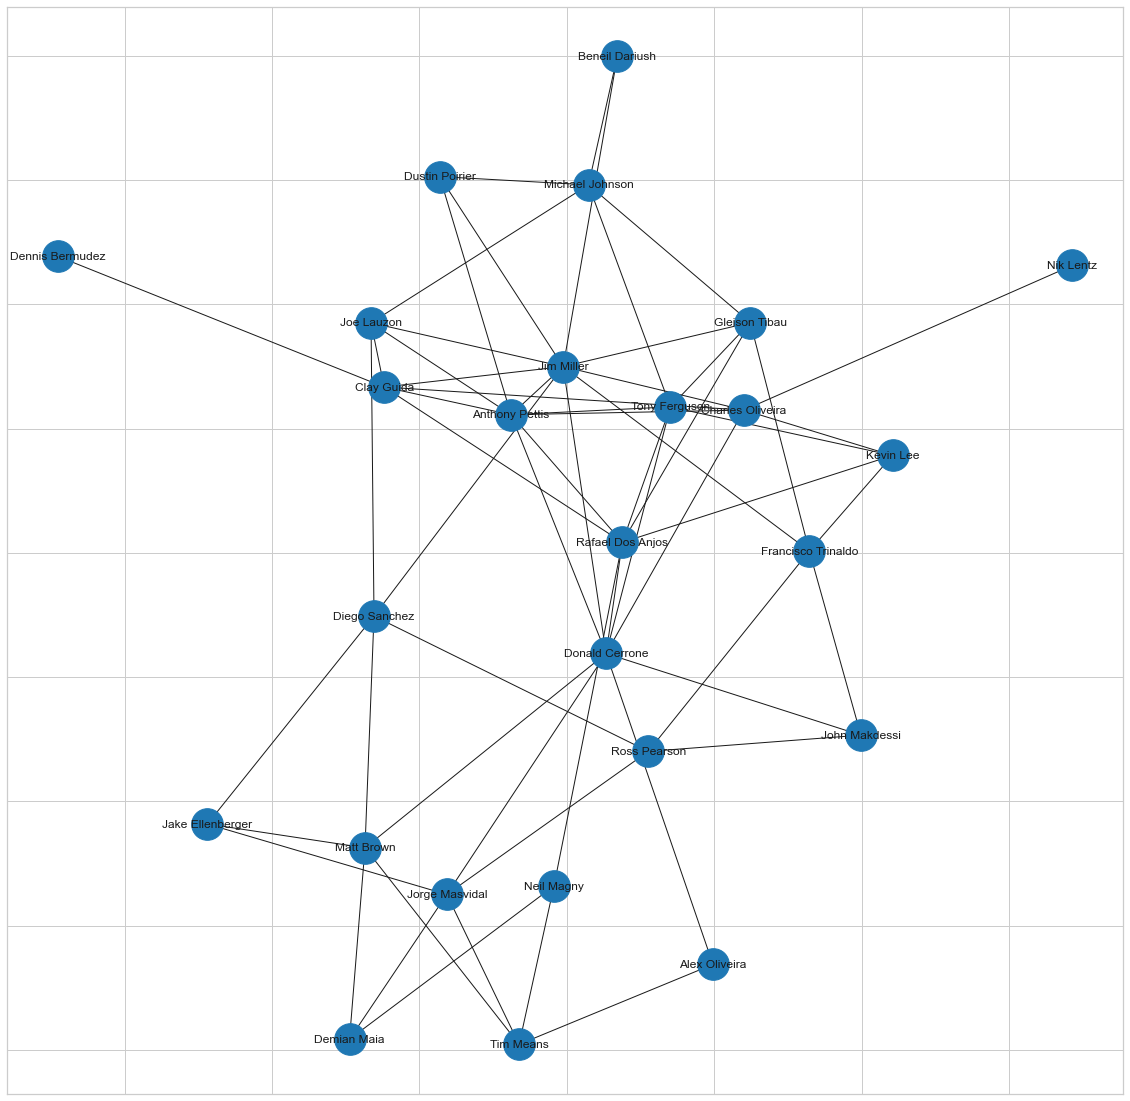

In [27]:
pos=nx.spring_layout(G)
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos=pos, node_size=1000, label=G.nodes, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)